<a href="https://colab.research.google.com/github/Takutino/AIT_finalProject_milestone/blob/main/DeepL_assignment2_takuto.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Copyright

<PRE>
Copyright (c) 2021 Bálint Gyires-Tóth - All Rights Reserved
You may use and modify this code for research and development purpuses.
Use this code for educational purposes (self-paced or instructor led) without the permission of the author is prohibited.
</PRE>

# Author classification
The task is to train a 1D CNN or an LSTM that is able to  classify text from two authors. The final model should be able to tell about a text with a given length (e.g. 60 characters) who wrote it. 

Please write the codes according to the following parts:

## Python module imports
Import all Python modules that you would need during the Assignment.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv1D, MaxPool1D, LSTM
import sys, re, cgi, random

## Data acquisition
Seek a possible dataset, you can use any source, e.g.
* http://www.gutenberg.org/
* https://www.kaggle.com/datasets
* https://paperswithcode.com/datasets
* if you would like to learn Hungarian, than e.g. https://mek.oszk.hu/

You can download the text by hand (e.g. by copy-pasting some parts into txt files) or with Python. 

In [ ]:
!wget https://www.gutenberg.org/files/5200/5200-0.txt
!wget https://www.gutenberg.org/files/64317/64317-0.txt

--2021-05-05 16:15:58--  https://www.gutenberg.org/files/5200/5200-0.txt
Resolving www.gutenberg.org (www.gutenberg.org)... 152.19.134.47, 2610:28:3090:3000:0:bad:cafe:47
Connecting to www.gutenberg.org (www.gutenberg.org)|152.19.134.47|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 142017 (139K) [text/plain]
Saving to: ‘5200-0.txt.2’

5200-0.txt.2        100%[===================>] 138.69K   490KB/s    in 0.3s    

2021-05-05 16:16:02 (490 KB/s) - ‘5200-0.txt.2’ saved [142017/142017]

--2021-05-05 16:16:02--  https://www.gutenberg.org/files/64317/64317-0.txt
Resolving www.gutenberg.org (www.gutenberg.org)... 152.19.134.47, 2610:28:3090:3000:0:bad:cafe:47
Connecting to www.gutenberg.org (www.gutenberg.org)|152.19.134.47|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 306258 (299K) [text/plain]
Saving to: ‘64317-0.txt.2’

64317-0.txt.2       100%[===================>] 299.08K   785KB/s    in 0.4s    

2021-05-05 16:16:07 (785 KB/s) - ‘

## Data loading, labeling and preprocessing
Load the data and convert the characters into one-hot encodings. Then load the data into a 3D NumPy array, with a shape of

* (batch, sequence_length, alphabet_length)

where sequence_length=60, and alphabet_length equals to the number of unique characters in both datasets. The sequences should be cut out from the complete dataset by sliding window. You should add 0 and 1 labels to the sequences, according to the author. 

Later you may change sequence_length to achieve better results!

In [ ]:
text_first = open("5200-0.txt", encoding='UTF-8').read().lower()
text_second = open("64317-0.txt", encoding='UTF-8').read().lower()


In [ ]:
text_final = text_first + text_second
chars = sorted(list(set(text_final)))
char_2_indices = dict((c, i) for i, c in enumerate(chars))
indices_2_char = dict((i, c) for i, c in enumerate(chars))

In [ ]:
char_2_indices

In [ ]:
indices_2_char

In [ ]:
# data preparation

seq_length = 60
step            = 60
sentences_one   = []
author_one = []

sentences_two = []
author_two = []

for i in range(0, len(text_first)-seq_length, step):
  sentences_one.append(text_first[i:i+seq_length]) # if i=0, text[0:60]
  author_one.append(text_first[i+seq_length])

for i in range(0, len(text_second)-seq_length, step):
  sentences_two.append(text_second[i:i+seq_length]) # if i=0, text[0:60]
  author_two.append(text_second[i+seq_length])



In [ ]:
X1 = np.zeros((len(sentences_one), seq_length, len(chars)))
Y1 = np.zeros((len(sentences_one), 1))

X2 = np.zeros((len(sentences_two), seq_length, len(chars)))
Y2 = np.zeros((len(sentences_two), 1))



In [ ]:
for i, sentence in enumerate(sentences_one): # go through all the sentences
  for t, char in enumerate(sentence):      # go through all the characters in all the sentences
    X1[i, t, char_2_indices[char]] = 1
  Y1[i, 0] = 0

for i, sentence in enumerate(sentences_two): # go through all the sentences
  for t, char in enumerate(sentence):      # go through all the characters in all the sentences
    X2[i, t, char_2_indices[char]] = 1
  Y2[i, 0] = 1

In [ ]:
# Combine two texts
X_final = np.concatenate((X1, X2), axis=0)
Y_final = np.concatenate((Y1, Y2), axis=0)

In [ ]:
# Shuffle texts randomly
import random

indices = np.arange(len(X_final))
random.shuffle(indices)
X_final = X_final[indices]
Y_final = Y_final[indices]

## Data splitting
Split the data into train, validate and test sets.

In [ ]:
  valid_split = 0.2
  test_split = 0.1
  
  valid_size = int(X_final.shape[0]*(1-valid_split-test_split))
  test_size = int(X_final.shape[0]*(1-test_split))

  X_train = X_final[0:valid_size]
  Y_train = Y_final[0:valid_size]
  X_valid = X_final[valid_size : test_size]
  Y_valid = Y_final[valid_size : test_size]
  X_test  = X_final[test_size:]
  Y_test  = Y_final[test_size:]

## Model definition
Define a 1D CNN or an LSTM for the task. Compile the model with the correct loss function.

In [ ]:
# 1D CNN
model = Sequential()
model.add(Conv1D(4, 3, activation='relu', kernel_initializer='he_normal',  input_shape=(X_final.shape[1], X_final.shape[2])))
model.add(MaxPool1D())
model.add(Conv1D(4, 3, activation='relu', kernel_initializer='he_normal'))
model.add(MaxPool1D())
model.add(Flatten())
model.add(Dense(1, activation='sigmoid'))


In [ ]:
# LSTM
# model = Sequential()
# model.add(LSTM(16, input_shape = (X_final.shape[1], X_final.shape[2])))
# model.add(Dense(1, activation='linear'))

In [ ]:
model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_16 (Conv1D)           (None, 58, 4)             832       
_________________________________________________________________
max_pooling1d_16 (MaxPooling (None, 29, 4)             0         
_________________________________________________________________
conv1d_17 (Conv1D)           (None, 27, 4)             52        
_________________________________________________________________
max_pooling1d_17 (MaxPooling (None, 13, 4)             0         
_________________________________________________________________
flatten_8 (Flatten)          (None, 52)                0         
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 53        
Total params: 937
Trainable params: 937
Non-trainable params: 0
________________________________________________________

In [ ]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

## Model training
Train the model and apply early stopping.

In [ ]:
from tensorflow.keras.callbacks import TensorBoard
tb = TensorBoard(log_dir='logs/baseline', histogram_freq=1, write_graph=1)
from tensorflow.keras.callbacks import EarlyStopping
es = EarlyStopping(patience=10, restore_best_weights=True)

In [ ]:
model.fit(X_train, Y_train, epochs=100, batch_size=16,
          validation_data=(X_valid, Y_valid), callbacks=[tb,es])

Epoch 1/100
313/313 [==============================] - 2s 5ms/step - loss: 0.6356 - accuracy: 0.6716 - val_loss: 0.6237 - val_accuracy: 0.6709
Epoch 2/100
313/313 [==============================] - 1s 4ms/step - loss: 0.6146 - accuracy: 0.6776 - val_loss: 0.6079 - val_accuracy: 0.6709
Epoch 3/100
313/313 [==============================] - 1s 5ms/step - loss: 0.5860 - accuracy: 0.6797 - val_loss: 0.5828 - val_accuracy: 0.6723
Epoch 4/100
313/313 [==============================] - 1s 5ms/step - loss: 0.5685 - accuracy: 0.6697 - val_loss: 0.5638 - val_accuracy: 0.6807
Epoch 5/100
313/313 [==============================] - 1s 5ms/step - loss: 0.5330 - accuracy: 0.7035 - val_loss: 0.5469 - val_accuracy: 0.7003
Epoch 6/100
313/313 [==============================] - 1s 5ms/step - loss: 0.5137 - accuracy: 0.7303 - val_loss: 0.5329 - val_accuracy: 0.7178
Epoch 7/100
313/313 [==============================] - 1s 4ms/step - loss: 0.4951 - accuracy: 0.7461 - val_loss: 0.5231 - val_accuracy: 0.7297

## Evaluation on test data
Evaluate the model on the test data in terms of loss and accuracy.

In [ ]:
preds = model.predict(X_test)

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
print("Accuracy: ", accuracy_score(np.argmax(Y_test,axis=1), np.round(preds)))
print("Precision: ", precision_score(np.argmax(Y_test,axis=1), np.round(preds), average='macro'))
print("Recall: ", recall_score(np.argmax(Y_test,axis=1), np.round(preds), average='macro'))
print("F1: ", f1_score(np.argmax(Y_test,axis=1), np.round(preds), average='macro'))

Accuracy:  0.2605042016806723
Precision:  0.5
Recall:  0.13025210084033614
F1:  0.2066666666666667


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Confusion matrix
Calculate and display the confusion matrix.

In [ ]:
from sklearn.metrics import confusion_matrix

In [ ]:
conf = confusion_matrix(Y_test, np.round(preds))

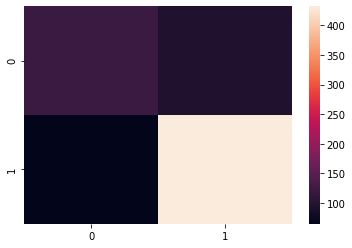

In [ ]:
import seaborn as sns

sns.heatmap(conf)